# MLIP and Espresso
In this tutorial, you'll learn how to train and deploy a machine-learned interatomic potential (MLIP) with espresso.
We'll be using the [apax](https://github.com/apaxhub/apax) MLIP <a href='#[1]'>[1]</a>.

Training an MLIP can take from a few minutes to weeks on multiple GPUs.
For this tutorial, the models you are using are pre-trained.
The training procedure is included in this repository and you could in principle add new model configurations.
The training workflow has been setup using the [IPSuite](https://github.com/zincware/ipsuite) package <a href='#[2]'>[2]</a>.
The training data is taken from the work of Cheng et al. <a href='#[3]'>[3]</a>.

In [1]:
import zntrack
import rdkit2ase
import matplotlib.pyplot as plt
import znh5md
from IPython.display import display, Markdown
from tqdm.auto import tqdm
import numpy as np
import datetime
import pint

ureg = pint.UnitRegistry()

We use the following default configuration for the apax MLIP training you're going to use.

In [2]:
with open("config/apax.yaml", "r") as f:
  content = f.read()
display(Markdown(f"```yaml\n{content}\n```"))

```yaml
n_epochs: 10_000
patience: 500
data_parallel: true
data:

  dataset:
    processing: cached

  batch_size: 1
  valid_batch_size: 40

metrics:
  - name: energy
    reductions: [mae]
  - name: forces
    reductions: [mae]

loss:
  - name: energy
    loss_type: nll
    weight: 1.
    atoms_exponent: 1
  - name: forces
    loss_type: nll
    weight: 2.
    atoms_exponent: 1

model:
  name: gmnn
  basis:
    name: bessel
    n_basis: 16
    r_max: 5.5

  n_radial: 6

  nn:
  - 128
  - 128

  ensemble:
    kind: shallow
    n_members: 16

  calc_stress: false
  use_ntk: false
  b_init: zeros
  w_init: lecun
  scale_shift_dtype: fp64
  descriptor_dtype: fp32
  readout_dtype: fp32

callbacks:
- name: csv

optimizer:
  name: adamw
  emb_lr:   0.0001
  nn_lr:    0.0001
  scale_lr: 0.0001
  shift_lr: 0.0001
  rep_scale_lr: 0.0001
  rep_prefactor_lr: 0.0001
  gradient_clipping: 10.0

  kwargs: 
    weight_decay: 0.0002
    b1: 0.85
    b2: 0.99

  schedule:
    name: cyclic_cosine
    period: 50
    decay_factor: 0.96

```

To gain a feel for different parameters, we have trained models with different values for the following parameters.
We have altered this configuration with respect to:
- **r_max**: The maximum cutoff radius for our descriptor, or in other words how far the model "sees" around the atom it is predicting the energy contribution and forces for. A small value will make the model very fast but can lead to physical inaccuracies or even instabilities. A large value will make the model slower but often more accurate.
- **n_basis**: The number of basis functions used in the descriptor. This describes how many basis functions are used and thus gives a measure on the complexity / resolution of the descriptor. A larger value corresponds to a more detailed description of the local atomic environment but also increases the computational cost.
- **nn**: The number and size of hidden layers in the neural network. More layers can increase the model's capacity to learn complex patterns but also make it more prone to overfitting.
- **n_radial**: The number of radial basis functions used in the descriptor. More radial functions can capture more details about the distances between atoms but also increase computational cost.

The workflow file `main.py` consists of the following steps:
1. Load the training and validation data from the `data/` folder.
2. Iterate over different model parameters and their configurations.
3. Write the configuration file for apax.
4. Configure the model training and evaluation.
5. Build the workflow.

The workflow has then been executed for you, and all the results are stored in the `nodes/` directory.

In [3]:
with open("main.py", "r") as f:
  content = f.read()
display(Markdown(f"```py\n{content}\n```"))

```py
from copy import deepcopy
from pathlib import Path

import ipsuite as ips
import yaml
from apax.nodes import Apax, ApaxBatchPrediction

reference = yaml.safe_load(Path("config/apax.yaml").read_text())

project = ips.Project()
with project:
    train = ips.AddDataH5MD(file="data/cosmo_water_train.h5")
    val = ips.AddDataH5MD(file="data/cosmo_water_val.h5")
    test = ips.AddDataH5MD(file="data/cosmo_water_test.h5")

for r_max in [2, 3, 4, 5, 5.5, 6]:
    with project.group("r_max", f"{r_max}".replace(".", "_")):
        config = deepcopy(reference)
        config["model"]["basis"]["r_max"] = r_max
        file = Path(f"config/apax-r_max-{r_max}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

for nn in [(16, 16), (32, 32), (64, 64), (128, 128)]:
    with project.group("nn", f"{nn[0]}-{nn[1]}"):
        config = deepcopy(reference)
        config["model"]["nn"] = list(nn)
        file = Path(f"config/apax-nn-{nn[0]}-{nn[1]}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

for n_basis in [4, 8, 16]:
    with project.group("n_basis", f"{n_basis}"):
        config = deepcopy(reference)
        config["model"]["basis"]["n_basis"] = n_basis
        file = Path(f"config/apax-n_basis-{n_basis}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

for n_radial in [5, 6, 7]:
    with project.group("n_radial", f"{n_radial}"):
        config = deepcopy(reference)
        config["model"]["n_radial"] = n_radial
        file = Path(f"config/apax-n_radial-{n_radial}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

if __name__ == "__main__":
    project.build()

```

You can select from the following models.
## Different NN sizes
The NN width and depth define the number of parameters of the neural network and thereby the model's capacity.
- `nn_16-16_Apax`, `nn_32-32_Apax`, `nn_64-64_Apax`, `nn_128-128_Apax`
## Different r max
The maxium radial cutoff defines how far the MLIP can "see" e.g. the size of the rezeptive field or the  size of a single local atomic environment.
- `r_max_2_Apax`, `r_max_3_Apax`, `r_max_4_Apax`, `r_max_5_Apax`, `r_max_5_5_Apax`,`r_max_6_Apax`
## Different n_basis
The number of bessel functions used to define the radial resolution within a local atomic environment.
-  `n_basis_4_Apax`, `n_basis_8_Apax`, `n_basis_16_Apax`
## Different n_radial
The angular resolution 
- `n_radial_5_Apax`, `n_radial_6_Apax`, `n_radial_7_Apax`

Let's load one of the models `r_max_5_5_Apax` and evaluate it.
For this purpose we'll be using the [ase](https://ase-lib.org/) package <a href='#[4]'>[4]</a>.
ASE allows you to define python objects that represent atomic structures.
Additionally, our (and most other MLIP) models provide an ASE calculator interface.
This interface will be used for the integration with Espresso later on as well.

To load the model, we use the [zntrack](https://zntrack.readthedocs.io/en/latest/) package <a href='#[5]'>[5]</a>.

A Note about units:
The ASE calculator and most MLIP packages use eV and Angstrom as units for energy and distance, as is referenced here https://ase-lib.org/ase/units.html.

In [4]:
model = zntrack.from_rev("r_max_5_5_Apax")
calc = model.get_calculator()
print(calc)

/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(


## Evaluate the MLIPs on the test dataset.
To assess the performance of our MLIPs, we can evaluate them on the provided test dataset.
These are configurations that the model has not seen during training and therefore can be used to assess the MLIPs static performance.
Note, that the values you gain from such static assessment depend on the quality and diversity of the test dataset.
Often, the evaluation on more real-world scenarios is required to obtain a comprehensive understanding of the model's capabilities.

In [5]:
test_io = znh5md.IO("data/cosmo_water_test.h5") # Test dataset stored in an adapted H5MD format.
test_frames = test_io[:]

The test_frames are a list of ase atoms objects.
Later on, you'll learn how to create your own configurations for e.g. running MD.

In [6]:
print(f"Number of test frames: {len(test_frames)}")
print(test_frames[:3])

Number of test frames: 160
[Atoms(symbols='H128O64', pbc=True, cell=[[13.066375, 0.0, 0.0], [-1e-06, 13.066375, 0.0], [-1e-06, -1e-06, 13.066375]], calculator=SinglePointCalculator(...)), Atoms(symbols='H128O64', pbc=True, cell=[[12.749514, 0.0, 0.0], [-1e-06, 12.749514, 0.0], [-1e-06, -1e-06, 12.749514]], calculator=SinglePointCalculator(...)), Atoms(symbols='H128O64', pbc=True, cell=[[13.096601, 0.0, 0.0], [-1e-06, 13.096601, 0.0], [-1e-06, -1e-06, 13.096601]], calculator=SinglePointCalculator(...))]


We can now use the `calc` object to apply the MLIP to compute energies and forces for each configuration in the test set.

In [7]:
true_energies = [x.get_potential_energy() for x in test_frames]
true_forces = [x.get_forces() for x in test_frames]
pred_energies = []
pred_forces = []
for frame in tqdm(test_frames):
    frame.calc = calc
    pred_energies.append(frame.get_potential_energy())
    pred_forces.append(frame.get_forces())

  0%|          | 0/160 [00:00<?, ?it/s]

neighbor list overflowed, reallocating.
neighbor list overflowed, reallocating.
neighbor list overflowed, reallocating.


**Exercise:**

* Plot the correlation plot (predicted vs true) for the DFT reference energies and forces compared to the MLIP predictions. The energy MAE is often given w.r.t. to the number of atoms.
* Compute the MAE for energies and forces.

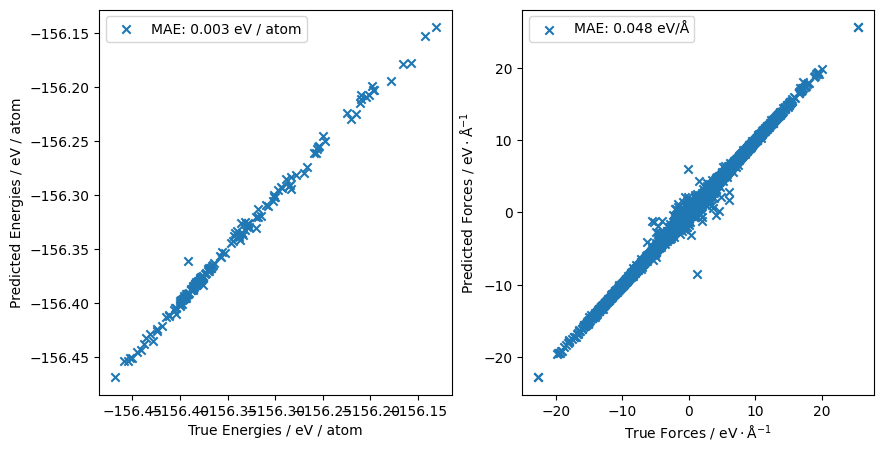

In [8]:
# SOLUTION CELL
fix, ax = plt.subplots(1, 2, figsize=(10, 5))

def mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

atoms = np.array([len(frame) for frame in test_frames])
true_energies_norm = np.array(true_energies) / atoms
pred_energies_norm = np.array(pred_energies) / atoms
e_mae = mae(true_energies_norm, pred_energies_norm)
ax[0].scatter(true_energies_norm, pred_energies_norm, marker="x", label=f"MAE: {e_mae:.3f} eV / atom")
ax[0].set_xlabel("True Energies / eV / atom")
ax[0].set_ylabel("Predicted Energies / eV / atom")
ax[0].legend()

true_forces_flat = np.concatenate([f.flatten() for f in true_forces])
pred_forces_flat = np.concatenate([f.flatten() for f in pred_forces])
f_mae = mae(true_forces_flat, pred_forces_flat)
ax[1].scatter(true_forces_flat, pred_forces_flat, marker="x", label=f"MAE: {f_mae:.3f} eV/Å")
ax[1].set_xlabel(r"True Forces / $\mathrm{eV \cdot \mathrm{\AA}^{-1}}$")
ax[1].set_ylabel(r"Predicted Forces / $\mathrm{eV \cdot \mathrm{\AA}^{-1}}$")
ax[1].legend()

Now, that you've looked at the performance of the ``r_max_5_5_Apax`` model, compute energy and force MAEs for the other models as well.
Are there trends that you can observe?

In [9]:
# SOLUTION CELL
model_names = [
    "nn_16-16_Apax", "nn_32-32_Apax", "nn_64-64_Apax", "nn_128-128_Apax",
    "r_max_2_Apax", "r_max_3_Apax", "r_max_4_Apax", "r_max_5_Apax", "r_max_5_5_Apax", "r_max_6_Apax",
    "n_basis_4_Apax", "n_basis_8_Apax", "n_basis_16_Apax",
    "n_radial_5_Apax", "n_radial_6_Apax", "n_radial_7_Apax"
]

def mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

atoms = np.array([len(frame) for frame in test_frames])
results = {}

pbar = tqdm(model_names)

for name in pbar:
    pbar.set_description(f"Evaluating {name}")
    model = zntrack.from_rev(name)
    calc = model.get_calculator()
    pred_energies = []
    pred_forces = []
    start = datetime.datetime.now()
    pred_frames = calc.batch_eval(test_frames, batch_size=1, silent=True)
    end = datetime.datetime.now()
    pred_energies = [x.get_potential_energy() for x in pred_frames]
    pred_forces = [x.get_forces() for x in pred_frames]
    pred_energies_norm = np.array(pred_energies) / atoms
    e_mae = mae(true_energies_norm, pred_energies_norm)
    pred_forces_flat = np.concatenate([f.flatten() for f in pred_forces])
    f_mae = mae(true_forces_flat, pred_forces_flat)
    results[name] = (e_mae, f_mae, end - start)

print("Model\t\tEnergy MAE (eV/atom)\tForce MAE (eV/Å)\tTime (s)")
for name, (e_mae, f_mae, duration) in results.items():
    print(f"{name}\t{e_mae:.4f}\t\t\t{f_mae:.4f}\t\t{duration.total_seconds():.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]

/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(
/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(
/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(
/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages

Model		Energy MAE (eV/atom)	Force MAE (eV/Å)	Time (s)
nn_16-16_Apax	0.0034			0.0485		6.1596
nn_32-32_Apax	0.0026			0.0458		6.0422
nn_64-64_Apax	0.0029			0.0503		5.7523
nn_128-128_Apax	0.0029			0.0474		5.1036
r_max_2_Apax	0.0479			0.3596		4.5155
r_max_3_Apax	0.0040			0.0919		4.3785
r_max_4_Apax	0.0031			0.0610		4.5838
r_max_5_Apax	0.0028			0.0483		5.1165
r_max_5_5_Apax	0.0026			0.0477		4.8303
r_max_6_Apax	0.0028			0.0440		5.2953
n_basis_4_Apax	0.0045			0.0543		4.7637
n_basis_8_Apax	0.0028			0.0477		4.8559
n_basis_16_Apax	0.0027			0.0474		4.8784
n_radial_5_Apax	0.0039			0.0548		5.5495
n_radial_6_Apax	0.0026			0.0471		4.8456
n_radial_7_Apax	0.0025			0.0461		6.4827


# Simulation Setup
MLIPs are different compared to classical force fields in their setup.
A classical force field requires a given topology, such that the parameters for inter and intramolecular interactions can be assigned.
These information are not required for MLIPs, as they learn the interactions from the training data.
Thus, the input to an MLIP is simply the atomic species and their positions.
Nevertheless, it is difficult to create such input files by hand and thus we make use of the SMILES representation of molecules <a href='#[6]'>[6]</a>.
For water, the SMILES string is simply `O`.
The [rdkit2ase](https://zincware.github.io/rdkit2ase/) package provides convient functions to setup systems connecting different tools.

The water molecule as ASE atoms object: Atoms(symbols='OH2', pbc=False)
Chemical species ['O', 'H', 'H'] and positions: 
[[-0.00570308  0.38515871 -0.        ]
 [-0.79607794 -0.194675   -0.        ]
 [ 0.80178102 -0.1904837   0.        ]]


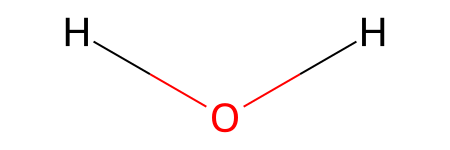

In [10]:
water = rdkit2ase.smiles2conformers("O", numConfs=100)
print(f"The water molecule as ASE atoms object: {water[0]}")
print(f"Chemical species {water[0].get_chemical_symbols()} and positions: \n{water[0].get_positions()}")
rdkit2ase.ase2rdkit(water[0])

We can now create a box at a given density and number of molecules to use for our MD simulation.
For this, we utilize the PACKMOL package.

In [11]:
box = rdkit2ase.pack([water], counts=[100], density=997, packmol="/data/fzills/tools/packmol-20.15.1/packmol")

Remember, for our model, this box is just XYZ coordinates, cell vectors, and atomic species.
But we can assign our model and compute energies and forces.

In [12]:
box.calc = calc

In [13]:
energy = box.get_potential_energy() * ureg.eV
print(f"Potential energy of the box: {energy:.2f~P}")

Potential energy of the box: -46866.79 eV


In [14]:
forces = box.get_forces() * ureg.eV / ureg.angstrom
print(f"Forces on the atoms (first 5 shown): {forces[:5]:.2f~P}")

Forces on the atoms (first 5 shown): [[-0.03 0.75 -0.22] [1.49 0.88 0.37] [-2.01 -0.34 0.23] [0.08 -0.32 1.25] [-0.36 1.13 -0.14]] eV/Å


One special aspect of the apax MLIP you are using is its ability to estimate the uncertainty of its predictions.
It uses a shallow ensemble approach, where the last layer of the neural network is replicated $N$ times with different random initializations and the mean is used as the final prediction.
This is configured via 
```yaml
ensemble:
    kind: shallow
    n_members: 16
```
This allows us to compute the standard deviation of the ensemble members as a measure of uncertainty.
You can access the uncertainty for the energy and forces through the calculator results.
We can use this information to monitor the uncertainty during an MD simulation and stop the simulation if the uncertainty exceeds a certain threshold.

In [15]:
print(box.calc.results.keys())

dict_keys(['energy', 'energy_ensemble', 'energy_uncertainty', 'forces', 'forces_ensemble', 'forces_uncertainty'])


In [16]:
energy_uncertainty = box.calc.results['energy_uncertainty'] * ureg.eV
print(f"Energy {energy:~.2P} ± {energy_uncertainty:~.2P}")

Energy -4.7e+04 eV ± 7.3 eV


With this input configured, we can continue setting up the MD simulation in espresso.

In [17]:
from ase.io import write

write('water.xyz', box)

## References

<a id='[1]'></a>[1] Moritz R. Schäfer, Nico Segreto, Fabian Zills, Christian Holm, and Johannes Kästner <a href="https://doi.org/10.1021/acs.jcim.5c01221">Apax: A Flexible and Performant Framework for the Development of Machine-Learned Interatomic Potentials</a> Journal of Chemical Information and Modeling 2025 65 (15), 8066-8078

<a id='[2]'></a>[2] Fabian Zills, Moritz René Schäfer, Nico Segreto, Johannes Kästner, Christian Holm, and Samuel Tovey <a href="https://doi.org/10.1021/acs.jpcb.3c07187">Collaboration on Machine-Learned Potentials with IPSuite: A Modular Framework for Learning-on-the-Fly</a>
The Journal of Physical Chemistry B 2024 128 (15), 3662-3676

<a id='[3]'></a>[3] B. Cheng,E.A. Engel,J. Behler,C. Dellago, & M. Ceriotti,  <a href="https://doi.org/10.1073/pnas.1815117116">Ab initio thermodynamics of liquid and solid water</a>, Proc. Natl. Acad. Sci. U.S.A. 2019 116 (4) 1110-1115

<a id='[4]'></a>[4] Ask Hjorth Larsen et al <a href="https://iopscience.iop.org/article/10.1088/1361-648X/aa680e">The atomic simulation environment—a Python library for working with atoms</a> 2017 J. Phys.: Condens. Matter 29 273002

<a id='[5]'></a>[5] Fabian Zills, Moritz Schäfer, Samuel Tovey, Johannes Kästner, Christian Holm <a href="https://doi.org/10.48550/arXiv.2401.10603">ZnTrack -- Data as Code</a> arXiv:2401.10603 [cs.MS] 2024

<a id='[6]'></a>[6] David Weininger: <a href="https://pubs.acs.org/doi/10.1021/ci00057a005">SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules.</a> Journal of Chemical Information and Computer Sciences. Band 28, Nr. 1, 1988, S. 31–36, doi:10.1021/ci00057a005